In [ ]:
one_month = '2023-11-13' #Change with your last downloaded day
six_month = '2023-06-13'
one_year = '2022-12-13'

In [1]:
from scipy.stats import zscore
import numpy as np
import pandas as pd
import tensorrt
import tensorflow as tf

2024-01-07 13:47:29.848877: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-07 13:47:29.849195: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-07 13:47:29.872426: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-07 13:47:29.953176: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-07 13:47:31.287215: W tensorflow/compiler/tf2

In [2]:
df_mut = pd.read_csv("mut.csv")
df_mut.set_index("fund_symbol", inplace=True)
df_mut.inception_date = pd.to_datetime(df_mut.inception_date)
print(df_mut.shape)
df_mut.head()

(15284, 43)


,initial_investment,fund_category,fund_family,investment_strategy,inception_date,investment_type,size_type,fund_return_1year,category_return_1year,fund_return_last_bull_market,...,company_6,ratio_6,company_7,ratio_7,company_8,ratio_8,company_9,ratio_9,company_10,ratio_10
fund_symbol,,,,,,,,,,,,,,,,,,,,,
AAAAX,1000.0,86,181,2062,2007-07-30,2,0,0.22970,0.2770,0.0811,...,7975.0,0.0156,7982.0,0.0146,7981.0,0.0144,7487.0,0.0139,NaN,0.0000
AAAEX,1000000.0,30,303,871,2020-07-13,0,0,0.23934,0.2486,0.1989,...,7487.0,0.0357,7979.0,0.0349,7979.0,0.0341,7487.0,0.0308,7974.0,0.0272
AAAGX,2000.0,40,295,742,1999-10-29,1,0,0.30705,0.4025,0.2719,...,7982.0,0.0464,7979.0,0.0374,7979.0,0.0313,7975.0,0.0295,7982.0,0.0292
AAAIX,5000000.0,3,38,1309,2000-08-01,0,0,0.19515,0.3401,0.2080,...,5567.0,0.0555,7487.0,0.0371,7487.0,0.0355,7487.0,0.0186,7974.0,0.0183
AAANX,2500.0,68,242,169,2012-01-31,0,0,0.24963,0.2798,0.0310,...,5567.0,0.0765,6235.0,0.0677,6879.0,0.0504,7487.0,0.0494,7974.0,0.0488


In [3]:
df_mut.columns

Index(['initial_investment', 'fund_category', 'fund_family',
       'investment_strategy', 'inception_date', 'investment_type', 'size_type',
       'fund_return_1year', 'category_return_1year',
       'fund_return_last_bull_market', 'category_return_last_bull_market',
       'category_return_2010', 'fund_return_2010', 'esg_peer_group',
       'environment_score', 'social_score', 'governance_score',
       'fund_median_market_cap', 'category_median_market_cap',
       'returns_as_of_date', 'fund_stdev_3years', 'fund_stdev_5years',
       'load_adj_return_1year', 'company_1', 'ratio_1', 'company_2', 'ratio_2',
       'company_3', 'ratio_3', 'company_4', 'ratio_4', 'company_5', 'ratio_5',
       'company_6', 'ratio_6', 'company_7', 'ratio_7', 'company_8', 'ratio_8',
       'company_9', 'ratio_9', 'company_10', 'ratio_10'],
      dtype='object')

In [4]:
df_mut = df_mut[['initial_investment', 'fund_category', 'fund_return_1year',
       'esg_peer_group', 'environment_score', 'social_score', 'governance_score']]

In [5]:
df_mut.isna().sum()

initial_investment    4963
fund_category            0
fund_return_1year      278
esg_peer_group           0
environment_score        0
social_score             0
governance_score         0
dtype: int64

In [6]:
df_mut.dropna(subset=['initial_investment'], inplace=True)
df_mut.dropna(inplace=True)
df_mut.shape

(10145, 7)

In [7]:
df_nav = pd.read_csv("current_nav.csv")
df_nav['Datetime'] = pd.to_datetime(df_nav['Datetime'])
df_nav.set_index('Datetime', inplace=True)
df_nav

,AAAAX,AAAGX,AAAIX,AAANX,AAAPX,AAAQX,AAARX,AAASX,AAAUX,AAAZX,...,WWSAX,WWSCX,WWSIX,WWWEX,WWWFX,YACKX,YAFFX,YAFIX,YCGEX,ZSCCX
Datetime,,,,,,,,,,,,,,,,,,,,,
2010-12-27,9.39,5.09,7.59,NaN,9.30,NaN,7.61,9.35,NaN,9.35,...,15.950000,15.070000,16.290000,4.65,37.250000,17.130000,18.030000,NaN,NaN,NaN
2010-12-28,9.38,5.08,7.57,NaN,9.30,NaN,7.60,9.34,NaN,9.34,...,15.900000,15.020000,16.230000,4.66,37.170000,17.140000,18.040000,NaN,NaN,NaN
2010-12-29,9.44,5.10,7.60,NaN,9.36,NaN,7.63,9.40,NaN,9.40,...,15.950000,15.070000,16.290000,4.71,37.370000,17.150000,18.050000,NaN,NaN,NaN
2010-12-30,9.39,5.09,7.60,NaN,9.34,NaN,7.62,9.33,NaN,9.32,...,15.930000,15.050000,16.270000,4.65,37.420000,16.530000,17.670000,NaN,NaN,NaN
2010-12-31,9.44,5.09,7.60,NaN,9.39,NaN,7.62,9.37,NaN,9.37,...,15.820000,14.950000,16.160000,4.67,37.250000,16.540000,17.680000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-07,11.16,14.84,7.24,13.39,11.04,11.21,7.36,11.08,7.21,11.09,...,21.389999,17.309999,23.900000,9.34,58.169998,23.190001,19.940001,19.889999,28.639999,32.490002
2023-12-08,11.15,14.90,7.24,13.43,11.03,11.20,7.37,11.07,7.22,11.08,...,21.540001,17.430000,24.070000,9.53,59.410000,23.340000,20.090000,20.040001,28.650000,32.779999
2023-12-11,11.15,14.91,7.27,13.50,11.03,11.20,7.40,11.07,7.25,11.08,...,21.730000,17.580000,24.270000,9.26,57.450001,23.420000,20.150000,20.100000,28.900000,32.919998


In [8]:
missing_values = df_nav.isna().sum()
columns_to_drop = missing_values[missing_values > 0].index
df_nav = df_nav.drop(columns=columns_to_drop)

In [9]:
df_nav

,AAAAX,AAAGX,AAAIX,AAAPX,AAARX,AAASX,AAAZX,AABCX,AABPX,AABTX,...,WWLAX,WWNPX,WWOCX,WWSAX,WWSCX,WWSIX,WWWEX,WWWFX,YACKX,YAFFX
Datetime,,,,,,,,,,,,,,,,,,,,,
2010-12-27,9.39,5.09,7.59,9.30,7.61,9.35,9.35,10.67,12.05,9.45,...,10.24,23.430000,7.23,15.950000,15.070000,16.290000,4.65,37.250000,17.130000,18.030000
2010-12-28,9.38,5.08,7.57,9.30,7.60,9.34,9.34,10.65,12.04,9.44,...,10.26,23.400000,7.25,15.900000,15.020000,16.230000,4.66,37.170000,17.140000,18.040000
2010-12-29,9.44,5.10,7.60,9.36,7.63,9.40,9.40,10.70,12.08,9.14,...,10.28,23.610000,7.29,15.950000,15.070000,16.290000,4.71,37.370000,17.150000,18.050000
2010-12-30,9.39,5.09,7.60,9.34,7.62,9.33,9.32,10.69,12.05,9.13,...,10.23,23.220000,7.24,15.930000,15.050000,16.270000,4.65,37.420000,16.530000,17.670000
2010-12-31,9.44,5.09,7.60,9.39,7.62,9.37,9.37,10.71,12.09,9.15,...,10.23,23.310000,7.24,15.820000,14.950000,16.160000,4.67,37.250000,16.540000,17.680000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-07,11.16,14.84,7.24,11.04,7.36,11.08,11.09,14.44,11.41,11.93,...,13.20,74.349998,11.44,21.389999,17.309999,23.900000,9.34,58.169998,23.190001,19.940001
2023-12-08,11.15,14.90,7.24,11.03,7.37,11.07,11.08,14.46,11.44,11.92,...,13.22,75.559998,11.48,21.540001,17.430000,24.070000,9.53,59.410000,23.340000,20.090000
2023-12-11,11.15,14.91,7.27,11.03,7.40,11.07,11.08,14.49,11.49,11.96,...,13.29,75.349998,11.53,21.730000,17.580000,24.270000,9.26,57.450001,23.420000,20.150000


In [10]:
fund_list = df_nav.columns.tolist()
df_mut = df_mut[df_mut.index.isin(fund_list)]

In [11]:
df_mut

,initial_investment,fund_category,fund_return_1year,esg_peer_group,environment_score,social_score,governance_score
fund_symbol,,,,,,,
AAAAX,1000.0,86,0.22970,81,8.42,7.43,5.43
AAAGX,2000.0,40,0.30705,38,2.04,10.13,8.03
AAAIX,5000000.0,3,0.19515,3,4.00,9.01,6.82
AAAPX,1000.0,86,0.22192,81,8.42,7.43,5.43
AAARX,2500.0,3,0.18624,3,4.00,9.01,6.82
...,...,...,...,...,...,...,...
WWSIX,500000.0,64,0.61670,59,0.00,0.00,0.00
WWWEX,2500.0,92,0.51660,85,0.00,0.00,0.00
WWWFX,2500.0,51,0.71690,38,0.00,0.00,0.00


In [12]:
numerical_columns = df_mut.select_dtypes(include=[np.number]).columns
df_mut[numerical_columns] = df_mut[numerical_columns].apply(zscore)

In [13]:
df_nav = df_nav[df_nav.columns[df_nav.columns.isin(df_mut.index.unique())]]
df_nav

,AAAAX,AAAGX,AAAIX,AAAPX,AAARX,AAASX,AAAZX,AABPX,AABTX,AACFX,...,WWLAX,WWNPX,WWOCX,WWSAX,WWSCX,WWSIX,WWWEX,WWWFX,YACKX,YAFFX
Datetime,,,,,,,,,,,,,,,,,,,,,
2010-12-27,9.39,5.09,7.59,9.30,7.61,9.35,9.35,12.05,9.45,21.170000,...,10.24,23.430000,7.23,15.950000,15.070000,16.290000,4.65,37.250000,17.130000,18.030000
2010-12-28,9.38,5.08,7.57,9.30,7.60,9.34,9.34,12.04,9.44,20.890000,...,10.26,23.400000,7.25,15.900000,15.020000,16.230000,4.66,37.170000,17.140000,18.040000
2010-12-29,9.44,5.10,7.60,9.36,7.63,9.40,9.40,12.08,9.14,21.120000,...,10.28,23.610000,7.29,15.950000,15.070000,16.290000,4.71,37.370000,17.150000,18.050000
2010-12-30,9.39,5.09,7.60,9.34,7.62,9.33,9.32,12.05,9.13,21.190000,...,10.23,23.220000,7.24,15.930000,15.050000,16.270000,4.65,37.420000,16.530000,17.670000
2010-12-31,9.44,5.09,7.60,9.39,7.62,9.37,9.37,12.09,9.15,21.390000,...,10.23,23.310000,7.24,15.820000,14.950000,16.160000,4.67,37.250000,16.540000,17.680000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-07,11.16,14.84,7.24,11.04,7.36,11.08,11.09,11.41,11.93,16.600000,...,13.20,74.349998,11.44,21.389999,17.309999,23.900000,9.34,58.169998,23.190001,19.940001
2023-12-08,11.15,14.90,7.24,11.03,7.37,11.07,11.08,11.44,11.92,16.530001,...,13.22,75.559998,11.48,21.540001,17.430000,24.070000,9.53,59.410000,23.340000,20.090000
2023-12-11,11.15,14.91,7.27,11.03,7.40,11.07,11.08,11.49,11.96,16.620001,...,13.29,75.349998,11.53,21.730000,17.580000,24.270000,9.26,57.450001,23.420000,20.150000


In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_copy = df_nav.copy()
df_copy.values[:,:] = scaler.fit_transform(df_copy.values)

# Replace the original DataFrame values with scaled values
df_nav.loc[:, :] = df_copy.values

/tmp/ipykernel_82285/260609417.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nav.loc[:, :] = df_copy.values


In [15]:
df_nav

,AAAAX,AAAGX,AAAIX,AAAPX,AAARX,AAASX,AAAZX,AABPX,AABTX,AACFX,...,WWLAX,WWNPX,WWOCX,WWSAX,WWSCX,WWSIX,WWWEX,WWWFX,YACKX,YAFFX
Datetime,,,,,,,,,,,,,,,,,,,,,
2010-12-27,0.272293,0.058668,0.560570,0.269663,0.541568,0.277689,0.277244,0.352941,0.151515,0.301913,...,0.221910,0.060917,0.029915,0.355168,0.492658,0.279849,0.127297,0.230094,0.219291,0.328084
2010-12-28,0.270701,0.058009,0.555819,0.269663,0.539192,0.276083,0.275641,0.351261,0.149495,0.288847,...,0.224719,0.060575,0.031624,0.352163,0.488987,0.276607,0.128609,0.228461,0.220115,0.328740
2010-12-29,0.280255,0.059328,0.562945,0.279294,0.546318,0.285714,0.285256,0.357983,0.088889,0.299580,...,0.227528,0.062971,0.035043,0.355168,0.492658,0.279849,0.135171,0.232544,0.220940,0.329396
2010-12-30,0.272293,0.058668,0.562945,0.276083,0.543943,0.274478,0.272436,0.352941,0.086869,0.302846,...,0.220506,0.058522,0.030769,0.353966,0.491189,0.278768,0.127297,0.233565,0.169827,0.304462
2010-12-31,0.280255,0.058668,0.562945,0.284109,0.543943,0.280899,0.280449,0.359664,0.090909,0.312179,...,0.220506,0.059548,0.030769,0.347356,0.483847,0.272825,0.129921,0.230094,0.170651,0.305118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-07,0.554140,0.701384,0.477435,0.548957,0.482185,0.555377,0.556090,0.245378,0.652525,0.088661,...,0.637640,0.641798,0.389744,0.682091,0.657122,0.690978,0.742782,0.657207,0.718879,0.453412
2023-12-08,0.552548,0.705339,0.477435,0.547351,0.484561,0.553772,0.554487,0.250420,0.650505,0.085394,...,0.640449,0.655601,0.393162,0.691106,0.665932,0.700162,0.767717,0.682523,0.731245,0.463255
2023-12-11,0.552548,0.705999,0.484561,0.547351,0.491686,0.553772,0.554487,0.258823,0.658586,0.089594,...,0.650281,0.653206,0.397436,0.702524,0.676946,0.710967,0.732283,0.642507,0.737840,0.467192


In [16]:
#For one month
start_date = pd.to_datetime(one_month)
end_date = df_nav.index.max()

train_set_1 = df_nav[df_nav.index < start_date]
test_set_1 = df_nav[(df_nav.index >= start_date) & (df_nav.index <= end_date)]

In [17]:
#For 6 months
start_date = pd.to_datetime(six_month)
end_date = df_nav.index.max()

train_set_6 = df_nav[df_nav.index < start_date]
test_set_6 = df_nav[(df_nav.index >= start_date) & (df_nav.index <= end_date)]

In [18]:
#For one year
start_date = pd.to_datetime(one_year)
end_date = df_nav.index.max()

train_set_y = df_nav[df_nav.index < start_date]
test_set_y = df_nav[(df_nav.index >= start_date) & (df_nav.index <= end_date)]

In [19]:
test_set_1

,AAAAX,AAAGX,AAAIX,AAAPX,AAARX,AAASX,AAAZX,AABPX,AABTX,AACFX,...,WWLAX,WWNPX,WWOCX,WWSAX,WWSCX,WWSIX,WWWEX,WWWFX,YACKX,YAFFX
Datetime,,,,,,,,,,,,,,,,,,,,,
2023-11-13,0.464968,0.668425,0.399050,0.460674,0.403801,0.465490,0.466346,0.159664,0.569697,0.118992,...,0.554775,0.672941,0.352137,0.643630,0.612335,0.653701,0.707349,0.607187,0.671064,0.421260
2023-11-14,0.515924,0.686223,0.434679,0.512039,0.441805,0.515249,0.517628,0.193277,0.604040,0.125525,...,0.588483,0.689368,0.367521,0.700721,0.668869,0.711507,0.708661,0.593508,0.704040,0.445538
2023-11-15,0.515924,0.686882,0.434679,0.512039,0.441805,0.515249,0.517628,0.194958,0.600000,0.141391,...,0.591292,0.687429,0.364957,0.703125,0.671072,0.714209,0.727034,0.621886,0.708162,0.450787
2023-11-16,0.509554,0.688200,0.429929,0.505618,0.437055,0.508828,0.511218,0.191597,0.604040,0.121792,...,0.591292,0.662218,0.368376,0.683293,0.651982,0.693679,0.703412,0.601674,0.704864,0.450131
2023-11-17,0.519108,0.686223,0.439430,0.515249,0.446556,0.520064,0.520833,0.203361,0.610101,0.122259,...,0.595506,0.674880,0.372650,0.694712,0.662996,0.705024,0.713911,0.606982,0.715581,0.456693
2023-11-20,0.530255,0.695452,0.448931,0.524880,0.456057,0.529695,0.532051,0.210084,0.618182,0.135324,...,0.601124,0.673283,0.376068,0.700721,0.668869,0.711507,0.719160,0.618416,0.722176,0.461942
2023-11-21,0.525478,0.693474,0.446556,0.521669,0.453682,0.526485,0.528846,0.206723,0.618182,0.132525,...,0.601124,0.670203,0.377778,0.680288,0.648311,0.690438,0.713911,0.610249,0.718054,0.458661
2023-11-22,0.527070,0.698088,0.451306,0.523274,0.458432,0.528090,0.528846,0.211765,0.620202,0.127392,...,0.609551,0.675108,0.384615,0.686298,0.654185,0.696921,0.729659,0.627807,0.720528,0.458005
2023-11-24,0.533439,0.697429,0.456057,0.528090,0.460808,0.532905,0.535256,0.211765,0.620202,0.128791,...,0.615169,0.679557,0.386325,0.692308,0.660059,0.702863,0.742782,0.640057,0.726298,0.461286


In [20]:
test_set_6

,AAAAX,AAAGX,AAAIX,AAAPX,AAARX,AAASX,AAAZX,AABPX,AABTX,AACFX,...,WWLAX,WWNPX,WWOCX,WWSAX,WWSCX,WWSIX,WWWEX,WWWFX,YACKX,YAFFX
Datetime,,,,,,,,,,,,,,,,,,,,,
2023-06-13,0.546178,0.613711,0.437055,0.544141,0.448931,0.547351,0.548077,0.196639,0.600000,0.191321,...,0.568820,0.547342,0.370940,0.718149,0.689427,0.727174,0.564304,0.345651,0.640561,0.414698
2023-06-14,0.550955,0.616348,0.437055,0.548957,0.448931,0.550562,0.552885,0.191597,0.602020,0.194120,...,0.564607,0.545631,0.375214,0.704928,0.676946,0.714209,0.564304,0.346060,0.633141,0.410105
2023-06-15,0.570064,0.628873,0.453682,0.566613,0.465558,0.569823,0.570513,0.210084,0.618182,0.212319,...,0.591292,0.558065,0.387179,0.712139,0.684288,0.721232,0.569554,0.353001,0.652927,0.422572
2023-06-16,0.573248,0.623599,0.448931,0.569823,0.460808,0.573034,0.573718,0.206723,0.614141,0.216986,...,0.589888,0.560233,0.388034,0.709135,0.681351,0.718531,0.580053,0.374847,0.652102,0.421916
2023-06-20,0.550955,0.622940,0.439430,0.548957,0.451306,0.550562,0.551282,0.196639,0.608081,0.189921,...,0.573034,0.549509,0.378633,0.703125,0.675477,0.712588,0.582677,0.394038,0.626546,0.402231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-07,0.554140,0.701384,0.477435,0.548957,0.482185,0.555377,0.556090,0.245378,0.652525,0.088661,...,0.637640,0.641798,0.389744,0.682091,0.657122,0.690978,0.742782,0.657207,0.718879,0.453412
2023-12-08,0.552548,0.705339,0.477435,0.547351,0.484561,0.553772,0.554487,0.250420,0.650505,0.085394,...,0.640449,0.655601,0.393162,0.691106,0.665932,0.700162,0.767717,0.682523,0.731245,0.463255
2023-12-11,0.552548,0.705999,0.484561,0.547351,0.491686,0.553772,0.554487,0.258823,0.658586,0.089594,...,0.650281,0.653206,0.397436,0.702524,0.676946,0.710967,0.732283,0.642507,0.737840,0.467192


In [21]:
import random
target_fund = random.choice(train_set_1.columns.tolist())
print("Target Mutual Fund:", target_fund)

Target Mutual Fund: GREZX


In [22]:
threshold = 0.5
step = 0.1
esg = df_mut[['environment_score', 'social_score', 'governance_score']]
def select_funds(train_set):
    correlation_matrix = train_set_1.corrwith(train_set_1[target_fund])
    high_corr_pairs = [(i, j) for i in range(correlation_matrix.shape[0]) 
                        for j in range(i+1, correlation_matrix.shape[0]) 
                        if abs(correlation_matrix.iloc[j]) > threshold]

    
    selected_funds = [target_fund]

    for i in range(5):
        lower_bound = i * step + threshold
        upper_bound = (i + 1) * step + threshold
        
        selected_pairs = [(train_set.columns[pair[0]], train_set.columns[pair[1]]) 
                        for pair in high_corr_pairs
                        if lower_bound <= abs(correlation_matrix.iloc[pair[1]]) < upper_bound
                        and (train_set.columns[pair[0]] == target_fund or train_set.columns[pair[1]] == target_fund)]
        funds = []
        for cor in selected_pairs:
            for fund in cor:
                if fund != target_fund:
                    funds.append(fund)
        try:
            funds = [item for sublist in selected_pairs for item in sublist if item != target_fund]
            funds_esg = esg.loc[funds]
            target_esg = esg.loc[target_fund]
            difference = funds_esg.sub(target_esg)
            absolute_difference = difference.abs()
            total_difference = absolute_difference.sum(axis=1)
            most_different_fund = total_difference.idxmax()
            most_neighbour_fund = total_difference.idxmin()
            selected_funds.append(most_different_fund)
            selected_funds.append(most_neighbour_fund)
        except:
            pass
    return selected_funds

In [23]:
selected_funds = select_funds(train_set_1)

In [24]:
train_set_1 = train_set_1[selected_funds]
test_set_1 = test_set_1[selected_funds]
train_set_6 = train_set_6[selected_funds]
test_set_6 = test_set_6[selected_funds]
train_set_y = train_set_y[selected_funds]
test_set_y = test_set_y[selected_funds]

In [25]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from keras.layers import LeakyReLU


Predict a month

In [26]:
y = train_set_1[target_fund]
X_train = train_set_1

In [27]:
X_train = X_train.ffill()
y = y.ffill()

y = y.values.reshape(-1, 1)
r, c = X_train.shape
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

n_lookback = len(2*test_set_1)             # length of input sequences (lookback period)
n_forecast = len(test_set_1)               # length of output sequences (forecast period)

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

In [28]:
import tensorflow as tf

gpu_available = tf.config.list_physical_devices('GPU')

if gpu_available:
    print("GPU is available.")
    for gpu in gpu_available:
        print(f"Device name: {gpu.name}, Device type: {gpu.device_type}")
else:
    print("GPU is not available. TensorFlow will use CPU.")


GPU is available.
Device name: /physical_device:GPU:0, Device type: GPU


2024-01-07 13:49:01.187815: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-07 13:49:01.278437: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-07 13:49:01.278486: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [29]:
import logging

from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.python.saved_model import tag_constants

logging.getLogger("tensorflow").setLevel(logging.ERROR)

# check TensorRT version
print("TensorRT version: ", trt._check_trt_version_compatibility)

TensorRT version:  <function _check_trt_version_compatibility at 0x7f63a47cf370>


In [30]:
is_cuda_gpu_available = tf.test.is_gpu_available(cuda_only=True)
is_cuda_gpu_available

2024-01-07 13:49:01.311551: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-07 13:49:01.311667: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-07 13:49:01.311696: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-07 13:49:01.712741: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-07 13:49:01.712929: I external/local_xla/xla/stream_executor

True

In [31]:
y.shape

(3242, 1)

In [32]:
features = 1
model_gru_future = Sequential()
model_gru_future.add(GRU(units=n_forecast, input_shape=(n_lookback, features)))
model_gru_future.add(Dense(n_forecast))
model_gru_future.add(LeakyReLU(alpha=0.01))
# Compiling the Gated Recurrent Unit
model_gru_future.compile(optimizer="Adam", loss="mse")

model_gru_future.summary()

2024-01-07 13:49:01.757608: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-07 13:49:01.757716: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-07 13:49:01.757745: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-07 13:49:01.758082: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-07 13:49:01.758094: I tensorflow/core/common_runtime/gpu/gpu

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 22)                1650      
                                                                 
 dense (Dense)               (None, 22)                506       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 22)                0         
                                                                 
Total params: 2156 (8.42 KB)
Trainable params: 2156 (8.42 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
model_gru_future.fit(X, Y, epochs=100, batch_size=4)

Epoch 1/100


2024-01-07 13:49:03.993594: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-07 13:49:04.430590: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f62810a0b40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-07 13:49:04.430642: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-01-07 13:49:04.463932: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  7/800 [..............................] - ETA: 7s - loss: 0.2747   

I0000 00:00:1704624544.722305   82523 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


800/800 [==============================] - 9s 9ms/step - loss: 0.0210
Epoch 2/100
800/800 [==============================] - 7s 8ms/step - loss: 0.0042
Epoch 3/100
800/800 [==============================] - 6s 8ms/step - loss: 0.0040
Epoch 4/100
800/800 [==============================] - 7s 8ms/step - loss: 0.0040
Epoch 5/100
800/800 [==============================] - 7s 9ms/step - loss: 0.0039
Epoch 6/100
800/800 [==============================] - 7s 9ms/step - loss: 0.0039
Epoch 7/100
800/800 [==============================] - 7s 9ms/step - loss: 0.0039
Epoch 8/100
800/800 [==============================] - 7s 9ms/step - loss: 0.0039
Epoch 9/100
800/800 [==============================] - 7s 9ms/step - loss: 0.0038
Epoch 10/100
800/800 [==============================] - 7s 9ms/step - loss: 0.0038
Epoch 11/100
800/800 [==============================] - 7s 9ms/step - loss: 0.0038
Epoch 12/100
800/800 [==============================] - 7s 9ms/step - loss: 0.0038
Epoch 13/100
800/800 [===

In [34]:
X_ = y[- n_lookback:]
X_ = X_.reshape(1, n_lookback, 1)
Y_ = model_gru_future.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_) 
pred = Y_.flatten()
test_set_1.loc[:, 'Predicted'] = pred

1/1 [==============================] - 0s 269ms/step


/tmp/ipykernel_82285/642735576.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_1.loc[:, 'Predicted'] = pred


In [35]:
import matplotlib.pyplot as plt
def plot_predictions(test_set, target_fund):
    test_set.plot(y=[target_fund, 'Predicted'])
    plt.title("Prediction")
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()

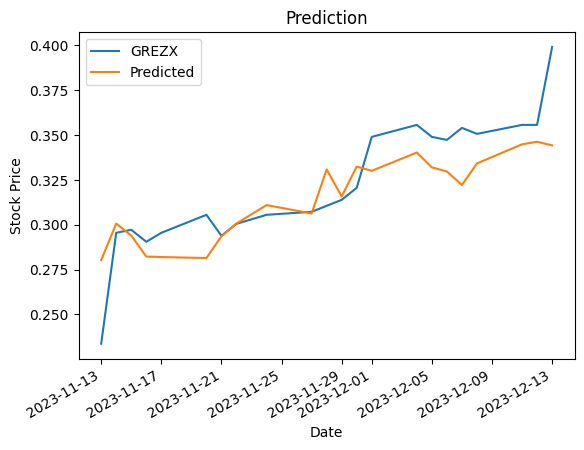

In [36]:
plot_predictions(test_set_1, target_fund)

In [37]:
def return_rmse(test, predicted):
    print("R2 Score: {:.2f}".format(r2_score(test, predicted)))
    print("MSE Score: {:.2f}".format(mean_squared_error(test, predicted)))
    print("RMSE Score: {:.2f}".format(np.sqrt(mean_squared_error(test, predicted))))
    print("MAE Score: {:.2f}".format(mean_absolute_error(test, predicted)))

In [38]:
return_rmse(test_set_1[target_fund].values, pred)

R2 Score: 0.65
MSE Score: 0.00
RMSE Score: 0.02
MAE Score: 0.02


In [141]:
y = train_set_6[target_fund]
X_train = train_set_6

In [142]:
X_train = X_train.ffill()
y = y.ffill()

y = y.values.reshape(-1, 1)
r, c = X_train.shape
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

n_lookback = len(test_set_6)               # length of input sequences (lookback period)
n_forecast = len(test_set_6)                 # length of output sequences (forecast period)

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

In [143]:
features = 1
model_gru_future = Sequential()
model_gru_future.add(GRU(units=n_forecast, input_shape=(n_lookback, features)))
model_gru_future.add(Dense(n_forecast))
model_gru_future.add(LeakyReLU(alpha=0.01))
# Compiling the Gated Recurrent Unit
model_gru_future.compile(optimizer="Adam", loss="mse")

model_gru_future.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_17 (GRU)                (None, 128)               50304     
                                                                 
 dense_17 (Dense)            (None, 128)               16512     
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 128)               0         
                                                                 
Total params: 66816 (261.00 KB)
Trainable params: 66816 (261.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [144]:
model_gru_future.fit(X, Y, epochs=400, batch_size=64)


Epoch 1/400
23/23 [==============================] - 3s 30ms/step - loss: 0.1921
Epoch 2/400
23/23 [==============================] - 0s 18ms/step - loss: 0.0231
Epoch 3/400
23/23 [==============================] - 0s 20ms/step - loss: 0.0145
Epoch 4/400
23/23 [==============================] - 0s 18ms/step - loss: 0.0138
Epoch 5/400
23/23 [==============================] - 0s 18ms/step - loss: 0.0137
Epoch 6/400
23/23 [==============================] - 0s 17ms/step - loss: 0.0137
Epoch 7/400
23/23 [==============================] - 0s 17ms/step - loss: 0.0137
Epoch 8/400
23/23 [==============================] - 0s 19ms/step - loss: 0.0136
Epoch 9/400
23/23 [==============================] - 0s 16ms/step - loss: 0.0136
Epoch 10/400
23/23 [==============================] - 0s 19ms/step - loss: 0.0137
Epoch 11/400
23/23 [==============================] - 0s 19ms/step - loss: 0.0136
Epoch 12/400
23/23 [==============================] - 0s 21ms/step - loss: 0.0135
Epoch 13/400
23/23 [=====

In [145]:
X_ = y[- n_lookback:]
X_ = X_.reshape(1, n_lookback, 1)
Y_ = model_gru_future.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)
pred = Y_.flatten()
test_set_6.loc[:, 'Predicted'] = pred

1/1 [==============================] - 0s 247ms/step


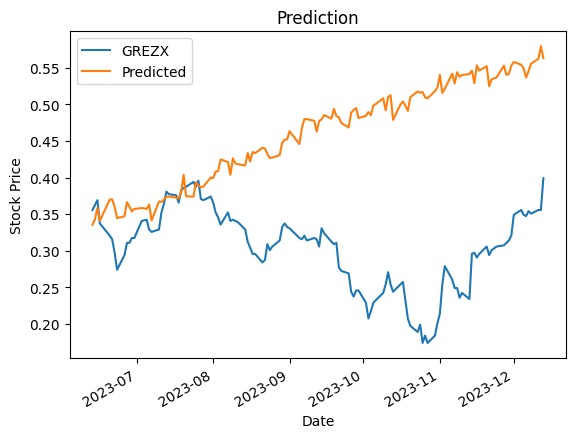

In [146]:
plot_predictions(test_set_6, target_fund)

In [147]:
return_rmse(test_set_6[target_fund].values, pred)

R2 Score: -11.12
MSE Score: 0.04
RMSE Score: 0.19
MAE Score: 0.16


Predict a year

In [148]:
y = train_set_y[target_fund]
X_train = train_set_y

In [149]:
X_train = X_train.ffill()
y = y.ffill()

y = y.values.reshape(-1, 1)
r, c = X_train.shape
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

n_lookback = len(test_set_y)               # length of input sequences (lookback period)
n_forecast = len(test_set_y)               # length of output sequences (forecast period)

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

In [150]:
features = 1
model_gru_future = Sequential()
model_gru_future.add(GRU(units=n_forecast, input_shape=(n_lookback, features)))
model_gru_future.add(Dense(n_forecast))
model_gru_future.add(LeakyReLU(alpha=0.01))
# Compiling the Gated Recurrent Unit
model_gru_future.compile(optimizer="Adam", loss="mse")

model_gru_future.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_18 (GRU)                (None, 252)               192780    
                                                                 
 dense_18 (Dense)            (None, 252)               63756     
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 252)               0         
                                                                 
Total params: 256536 (1002.09 KB)
Trainable params: 256536 (1002.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [151]:
model_gru_future.fit(X, Y, epochs=400, batch_size=64)


Epoch 1/400
40/40 [==============================] - 3s 33ms/step - loss: 0.1040
Epoch 2/400
40/40 [==============================] - 1s 28ms/step - loss: 0.0192
Epoch 3/400
40/40 [==============================] - 1s 31ms/step - loss: 0.0182
Epoch 4/400
40/40 [==============================] - 1s 28ms/step - loss: 0.0179
Epoch 5/400
40/40 [==============================] - 1s 25ms/step - loss: 0.0176
Epoch 6/400
40/40 [==============================] - 1s 31ms/step - loss: 0.0176
Epoch 7/400
40/40 [==============================] - 1s 28ms/step - loss: 0.0171
Epoch 8/400
40/40 [==============================] - 1s 25ms/step - loss: 0.0163
Epoch 9/400
40/40 [==============================] - 1s 28ms/step - loss: 0.0156
Epoch 10/400
40/40 [==============================] - 1s 31ms/step - loss: 0.0147
Epoch 11/400
40/40 [==============================] - 1s 30ms/step - loss: 0.0143
Epoch 12/400
40/40 [==============================] - 1s 29ms/step - loss: 0.0128
Epoch 13/400
40/40 [=====

In [152]:
X_ = y[- n_lookback:]
X_ = X_.reshape(1, n_lookback, 1)
Y_ = model_gru_future.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)
pred = Y_.flatten()
test_set_y.loc[:, 'Predicted'] = pred

1/1 [==============================] - 0s 325ms/step


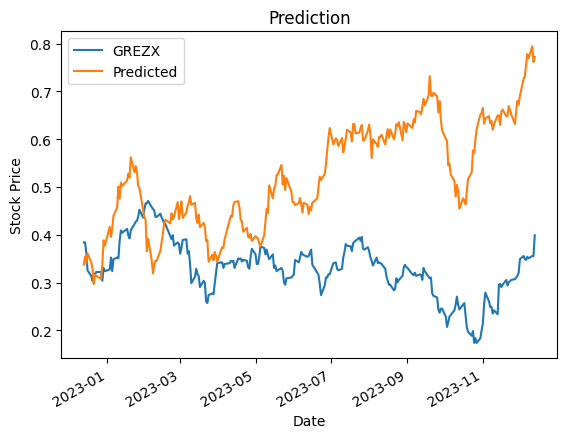

In [153]:
plot_predictions(test_set_y, target_fund)

In [154]:
return_rmse(test_set_y[target_fund].values, pred)

R2 Score: -15.71
MSE Score: 0.06
RMSE Score: 0.24
MAE Score: 0.20
